In [2]:
import pandas as pd
covid_data = pd.read_csv('data/covid_data.csv')
display(covid_data.head())

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0


In [3]:
vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations',
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

In [4]:
covid_data = covid_data.groupby(
    ['date', 'country'],
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

covid_data['date'] = pd.to_datetime(covid_data['date'])

covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered'] #the number of active infected

covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

display(covid_data.head())

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered
11337,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN
11570,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11807,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12051,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12299,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

In [6]:
print(f'{covid_data.date.dt.date.min()}-{covid_data.date.dt.date.max()}')


2020-01-22-2021-05-29


In [7]:
print(f'{vaccinations_data.date.dt.date.min()}-{vaccinations_data.date.dt.date.max()}')

2020-12-02-2021-09-06


In [8]:
covid_df = pd.merge(covid_data, vaccinations_data, on=['date','country'], how='left')
print(covid_df.shape)

(86785, 16)


In [9]:
covid_df['death_rate'] = (covid_df['deaths']/covid_df['confirmed'])*100
covid_df['recover_rate'] = (covid_df['recovered']/covid_df['confirmed'])*100
print(covid_df.groupby('country')['death_rate'].max()['United States'])

7.18954248366013


In [10]:
print(covid_df.groupby('country')['recover_rate'].mean()['Russia'])

67.06273489477655


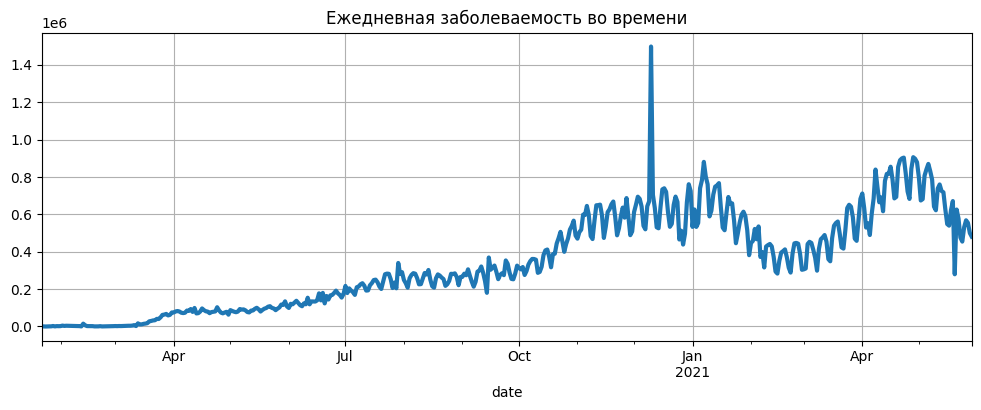

In [11]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12,4),
    title='Ежедневная заболеваемость во времени',
    grid=True,
    lw=3
);

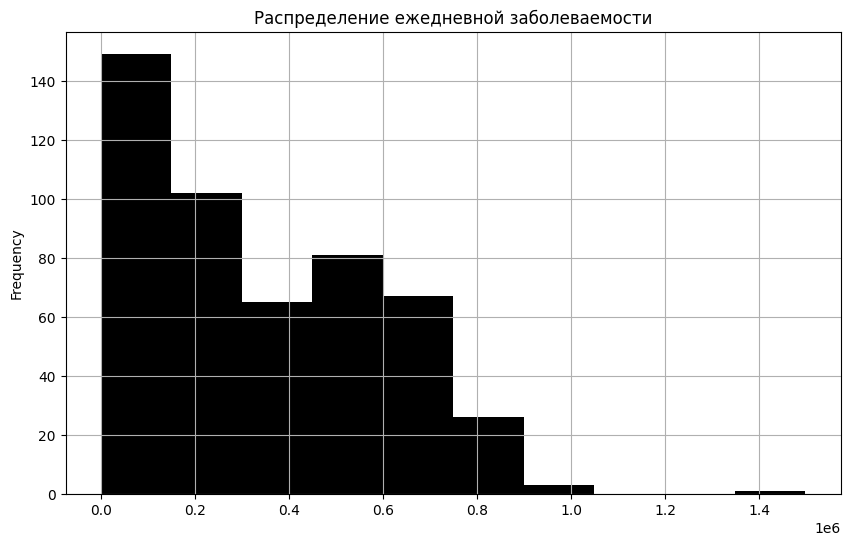

In [12]:
grouped_cases.plot(
    kind='hist',
    figsize=(10,6),
    title='Распределение ежедневной заболеваемости',
    grid=True,
    color='black',
    bins=10
);

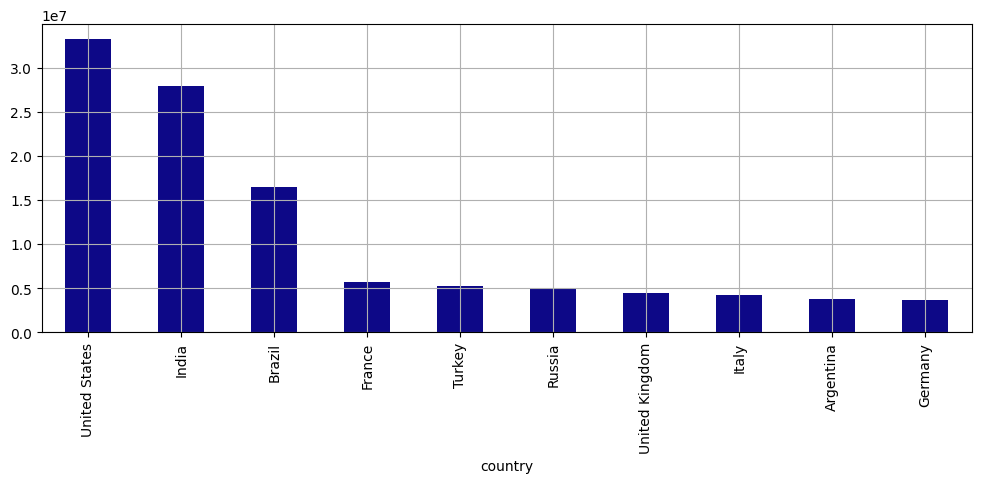

In [13]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12,4),
    colormap='plasma'
);


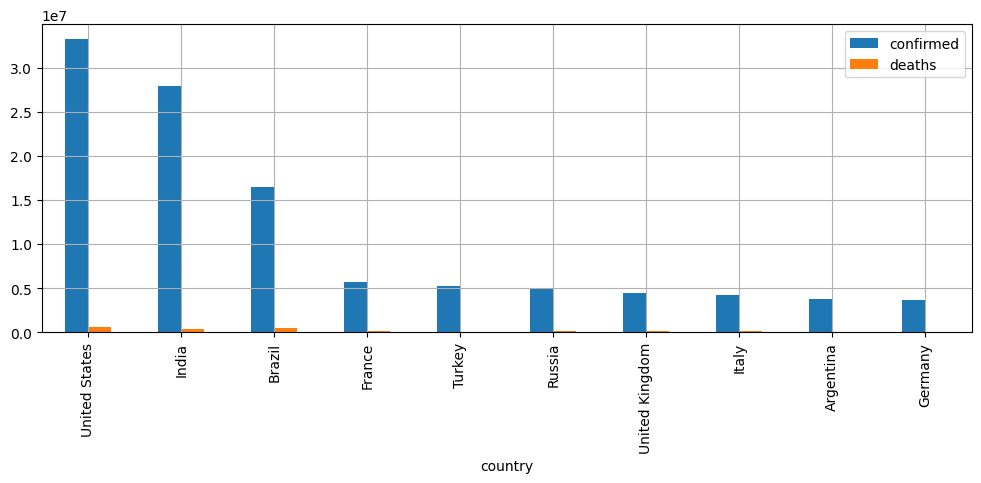

In [14]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12,4)
);

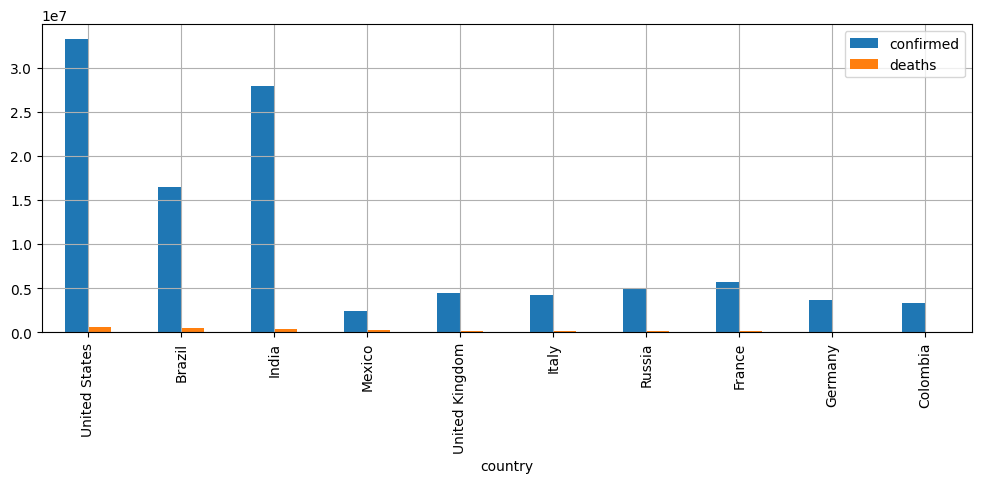

In [15]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['deaths'])
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12,4)
);

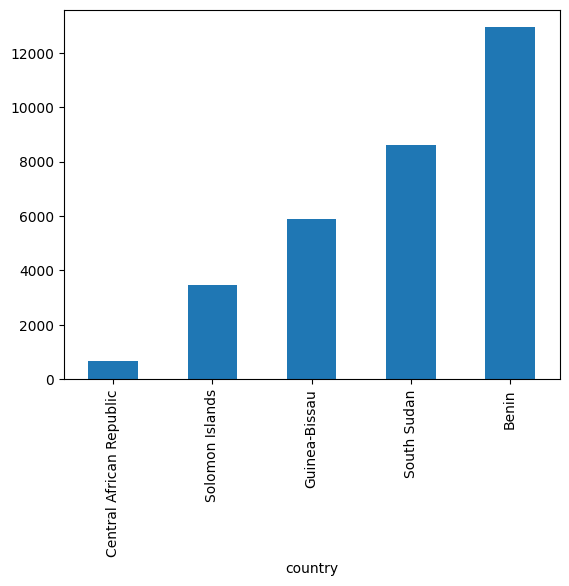

In [16]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar');

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

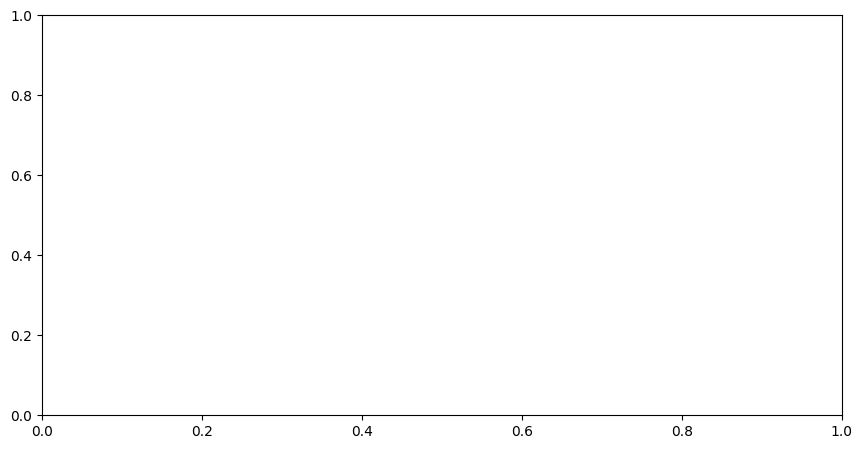

In [18]:
fig = plt.figure(figsize=(8,4))
axes = fig.add_axes([0,0,1,1])

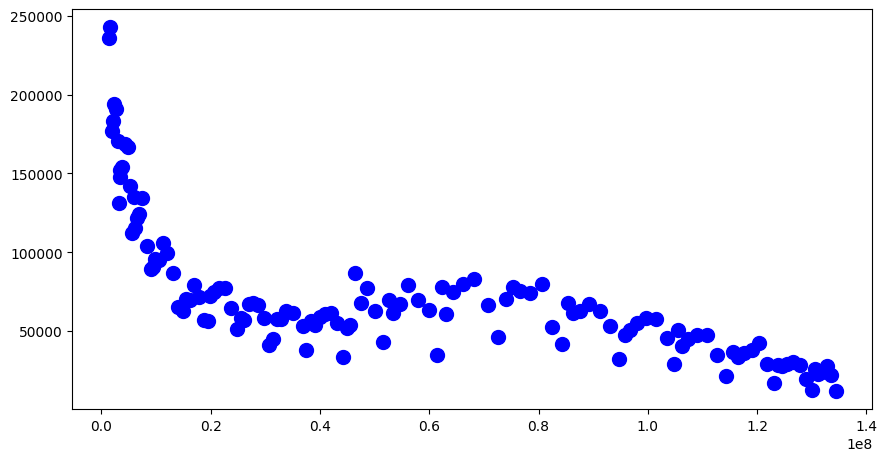

In [19]:
us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8,4))
axes = fig.add_axes([0,0,1,1])
axes.scatter(
    x=us_data['people_fully_vaccinated'],
    y=us_data['daily_confirmed'],
    s=100,
    marker='o',
    c='blue'
);

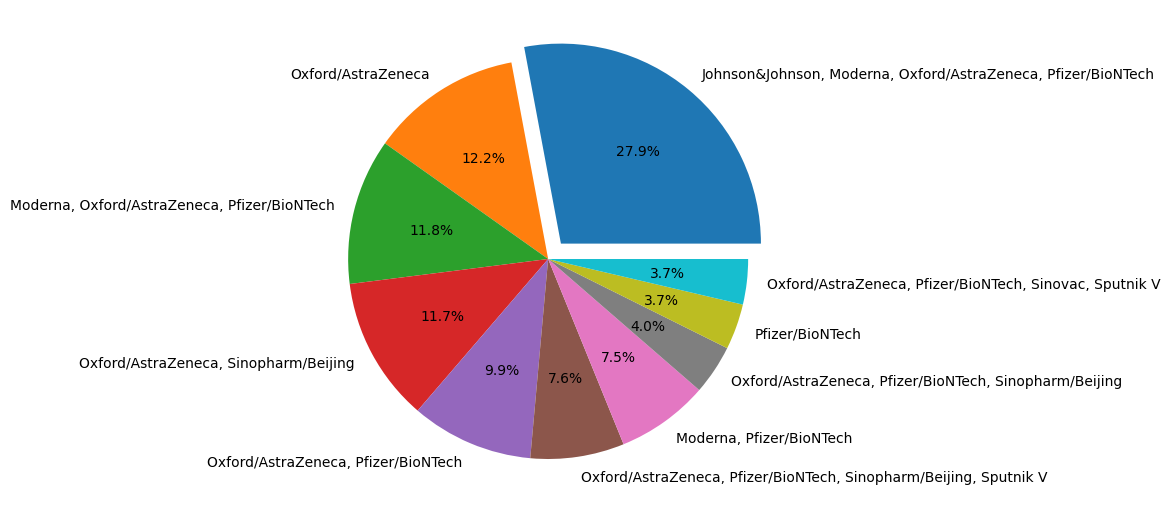

In [20]:
vaccine_combinations = covid_df['vaccines'].value_counts()[:10]
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode=[0.1,0,0,0,0,0,0,0,0,0]
);

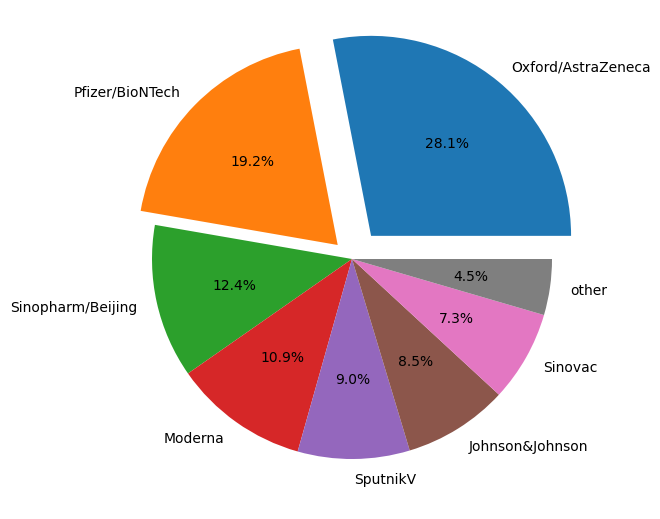

In [21]:
combination_not_nan = covid_df.dropna(subset=['vaccines'])
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last()
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(','))
vaccines_dict = {}
for vaccines_list in combination_last:
    for vaccine in vaccines_list:
        if vaccine not in vaccines_dict:
            vaccines_dict[vaccine] = 1
        else:
            vaccines_dict[vaccine] += 1
            
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    vaccines,
    labels=vaccines.index,
    autopct='%.1f%%',
    explode=[0.15,0.1,0,0,0,0,0,0]
);

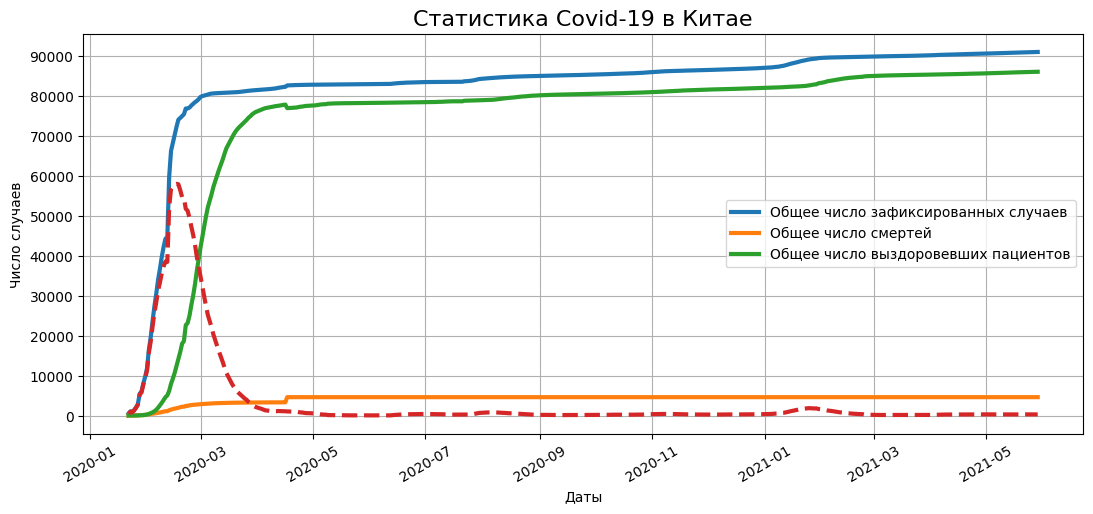

In [22]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby('date')[['confirmed', 'active', 'deaths', 'recovered']].sum()

fig = plt.figure(figsize=(10,4))
axes = fig.add_axes([0,0,1,1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='', lw=3, linestyle='dashed')

axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0,100000,10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

In [23]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

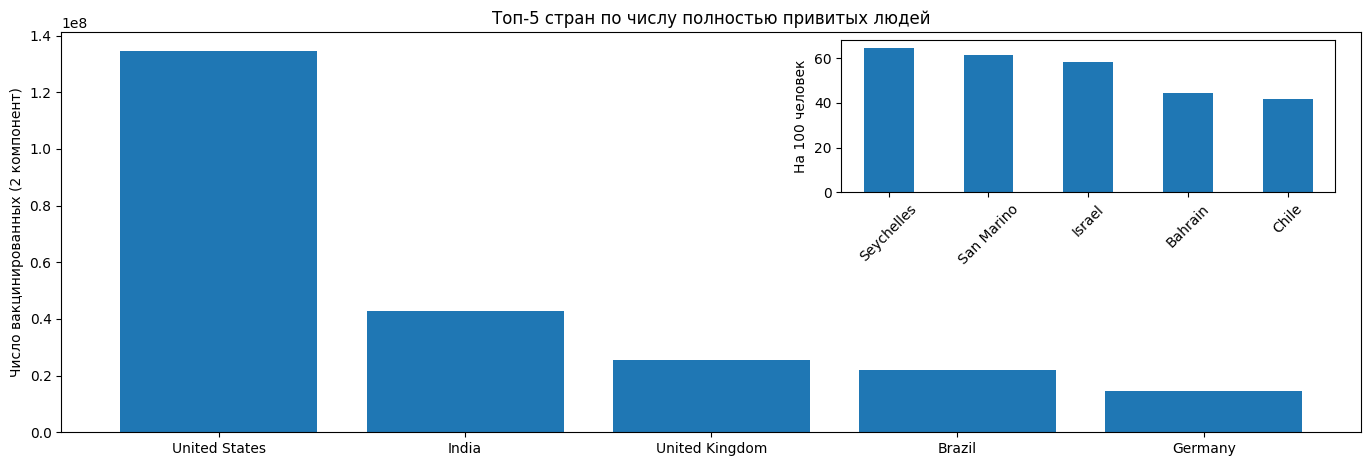

In [24]:
#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x=vacc_country.index, height=vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ-5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(x=vacc_country_per_hundred.index, height=vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=45)

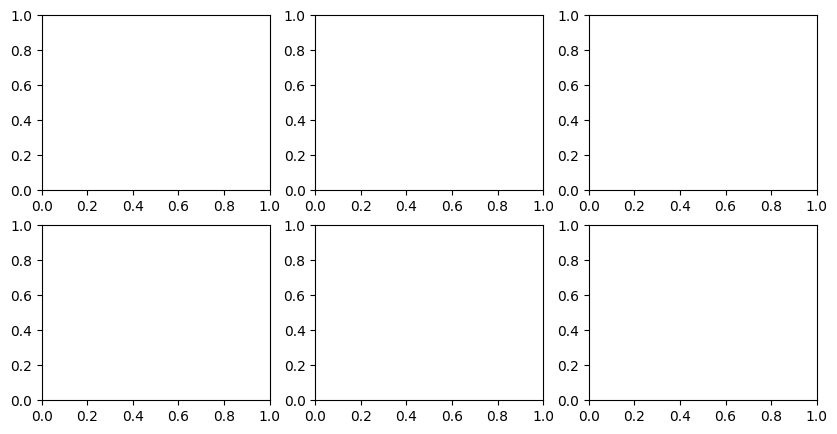

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

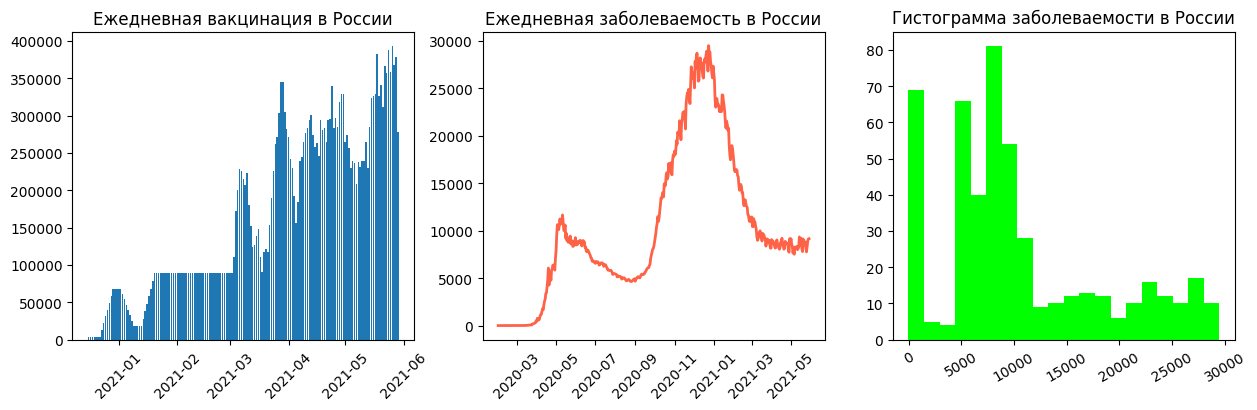

In [26]:
russia_data = covid_df[covid_df['country'] == 'Russia']

# визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

# столбчатая диаграмма
axes[0].bar(
    x=russia_data['date'],
    height=russia_data['daily_vaccinations'],
    label='Число вакцинированных'
)
axes[0].set_title('Ежедневная вакцинация в России')
axes[0].xaxis.set_tick_params(rotation=45)

# линейный график
axes[1].plot(
    russia_data['date'],
    russia_data['daily_confirmed'],
    label='Число заболевших',
    color='tomato',
    lw=2
)
axes[1].set_title('Ежедневная заболеваемость в России')
axes[1].xaxis.set_tick_params(rotation=45)

# гистограмма
axes[2].hist(
    x=russia_data['daily_confirmed'],
    label=['Число заболевших'],
    color='lime',
    bins=20
)
axes[2].set_title('Гистограмма заболеваемости в России')
axes[2].xaxis.set_tick_params(rotation=30)

In [27]:
display(covid_df.head())

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate
0,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [28]:
covid_df.to_csv('data/covid_df.csv', index=False)

In [29]:
covid_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 86785 entries, 0 to 86784
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 86785 non-null  datetime64[us]
 1   country                              86785 non-null  str           
 2   confirmed                            86785 non-null  float64       
 3   deaths                               86785 non-null  float64       
 4   recovered                            86785 non-null  float64       
 5   active                               86785 non-null  float64       
 6   daily_confirmed                      86564 non-null  float64       
 7   daily_deaths                         86564 non-null  float64       
 8   daily_recovered                      86564 non-null  float64       
 9   total_vaccinations                   10629 non-null  float64       
 10  people_vaccinated    